<img src="../images/logos/wradlib_logo.svg.png" width=250 alt="wradlib logo png"></img>

# wradlib radar data io, visualisation, gridding and gis export

---

## Overview

Within this notebook, we will cover:

1. Reading radar volume data into xarray based RadarVolume
1. Examination of RadarVolume and Sweeps
1. Plotting of sweeps, simple and mapmaking
1. Gridding and GIS output

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Xarray Basics](https://tutorial.xarray.dev/intro.html) | Helpful | Basic Dataset/DataArray |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | Basic Plotting |
| [Cartopy Basics](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Projections |
| [GDAL Basiscs](https://gdal.org/api/python_bindings.html) | Helpful | Raster |

- **Time to learn**: 15 minutes

---

## Imports

In [1]:
import glob
import pathlib

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import ticker as tick
from osgeo import gdal

import wradlib as wrl
import xradar as xd

## Import data into RadarVolume

We have this special case here with Rainbow data where moments are splitted across files. Each file nevertheless consists of all sweeps comprising the volume. We'll use some special nested ordering to read the files.

In [2]:
fglob = "data/rainbow/meteoswiss/*.vol"

In [3]:
vol = wrl.io.open_rainbow_mfdataset(fglob, combine="by_coords", concat_dim=None)

D:\Miniconda3\envs\wradlib\Lib\site-packages\wradlib\io\rainbow.py:222: FutureWarning: `open_rainbow_mfdataset` is deprecated and will be removed in 2.0. Future development will take place in `xradar`-package.
  return open_radar_mfdataset(


  0%|          | 0/10 [00:00<?, ?it/s]

Note that we get a warning because this method of loading data will be deprecated in the future in favor of the xradar package. More on alternative loading methods below.

### Examine RadarVolume

The RadarVolume is a shallow class which tries to comply to CfRadial2/WMO-FM301, see [WMO-CF_Extensions](https://community.wmo.int/activity-areas/wis/wmo-cf-extensions).

The printout of `RadarVolume` just lists the dimensions and the associated elevations.

In [4]:
display(vol)

<wradlib.RadarVolume>
Dimension(s): (sweep: 10)
Elevation(s): (0.0, 1.3, 2.9, 4.9, 7.3, 10.2, 13.8, 18.2, 23.5, 30.0)

### Root Group

The root-group is essentially an overview over the volume, more or less aligned with CfRadial metadata.

In [5]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 10)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int32 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2019-10-21T08:24:09Z'
    time_coverage_end    <U20 '2019-10-21 08:29:34Z'
    latitude             float64 46.77
    longitude            float64 6.954
    altitude             float64 735.0
    sweep_group_name     (sweep) <U7 'sweep_0' 'sweep_1' ... 'sweep_8' 'sweep_9'
    sweep_fixed_angle    (sweep) float64 0.0 1.3 2.9 4.9 ... 13.8 18.2 23.5 30.0
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      0.0

### Sweep Groups

Sweeps are available in a sequence attached to the `RadarVolume` object.

In [6]:
swp = vol[0]
display(swp)

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 1400)
Coordinates:
  * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * range              (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
    elevation          (azimuth) float64 dask.array<chunksize=(360,), meta=np.ndarray>
    rtime              (azimuth) datetime64[ns] dask.array<chunksize=(360,), meta=np.ndarray>
    sweep_mode         <U20 'azimuth_surveillance'
    longitude          float64 6.954
    latitude           float64 46.77
    altitude           float64 735.0
    time               datetime64[ns] 2019-10-21T08:24:09.041666500
Data variables:
    DBZH               (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    sweep_number       int32 0
    prt_mode           <U7 'not_set'
    follow_mode        <U7 'not_set'
    sweep_fixed_angle  float64 0.0
    KDP                (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    PHIDP              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    RHOHV              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    VRADH              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    WRADH              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    ZDR                (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
Attributes:
    fixed_angle:  0.0

## Inspect Scan Strategy

Considering volume files it's nice to have an overview over the scan strategy. We can choose some reasonable values for the layout.

In [7]:
# Number of azimuths (rays)
swp["azimuth"].count()

<xarray.DataArray 'azimuth' ()>
array(360)
Coordinates:
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 6.954
    latitude    float64 46.77
    altitude    float64 735.0
    time        datetime64[ns] 2019-10-21T08:24:09.041666500

In [8]:
# Number of range bins and resolution
swp["range"]

<xarray.DataArray 'range' (range: 1400)>
array([2.5000e+01, 7.5000e+01, 1.2500e+02, ..., 6.9875e+04, 6.9925e+04,
       6.9975e+04], dtype=float32)
Coordinates:
  * range       (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 6.954
    latitude    float64 46.77
    altitude    float64 735.0
    time        datetime64[ns] 2019-10-21T08:24:09.041666500
Attributes:
    units:                           meters
    standard_name:                   projection_range_coordinate
    long_name:                       range_to_measurement_volume
    axis:                            radial_range_coordinate
    meters_between_gates:            50.0
    spacing_is_constant:             true
    meters_to_center_of_first_gate:  25.0

In [9]:
# Elevations
vol.root.sweep_fixed_angle.values

array([ 0. ,  1.3,  2.9,  4.9,  7.3, 10.2, 13.8, 18.2, 23.5, 30. ])

In [12]:
nrays = 360
nbins = 1400
range_res = 50
ranges = np.arange(nbins) * range_res
elevs = vol.root.sweep_fixed_angle.values
sitecoords = (
    vol.root.longitude.values.item(),
    vol.root.latitude.values.item(),
    vol.root.altitude.values.item(),
)

beamwidth = 1.0 # this is unfortunately not in the volume, we need to know this from somewhere else

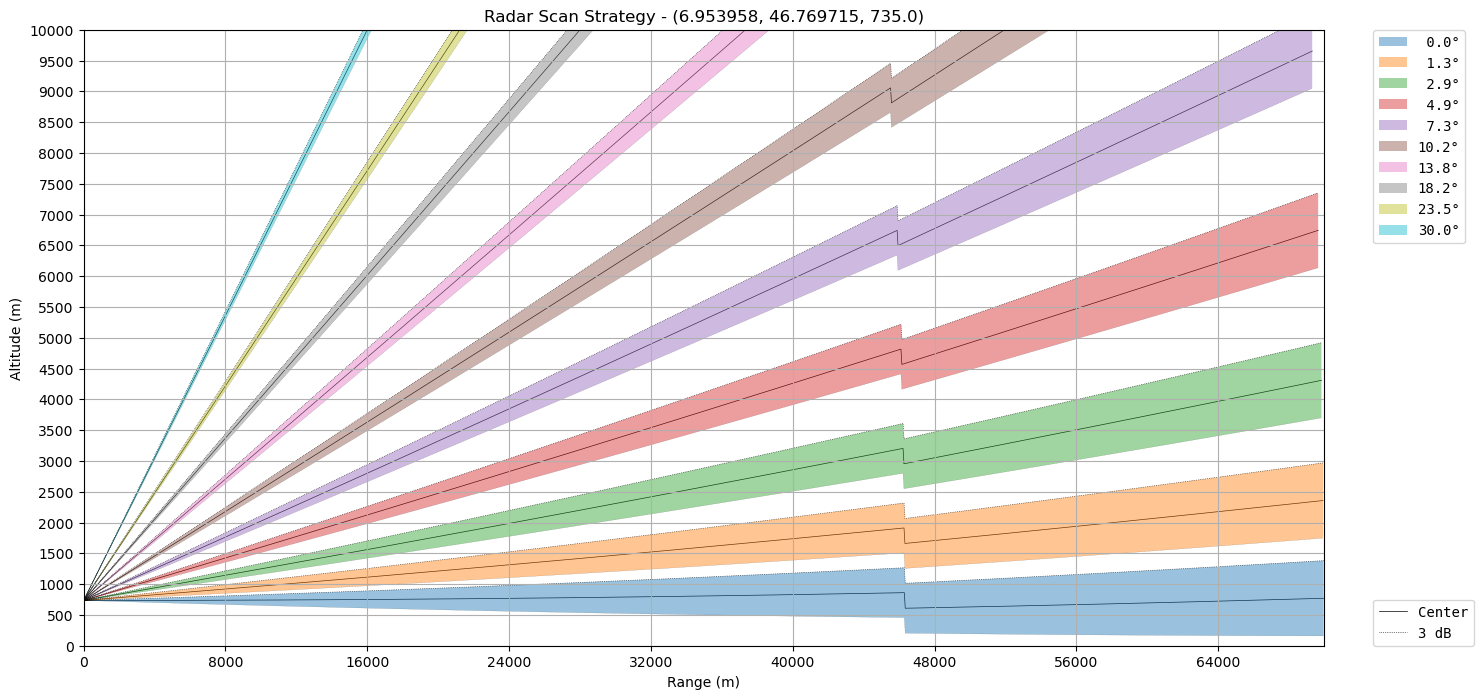

In [13]:
ax = wrl.vis.plot_scan_strategy(ranges, elevs, sitecoords)

We can plot it on top of the terrain derived from SRTM DEM.

In [14]:
import os

os.environ["WRADLIB_EARTHDATA_BEARER_TOKEN"] = ""
os.environ["WRADLIB_DATA"] = "data/wradlib-data"

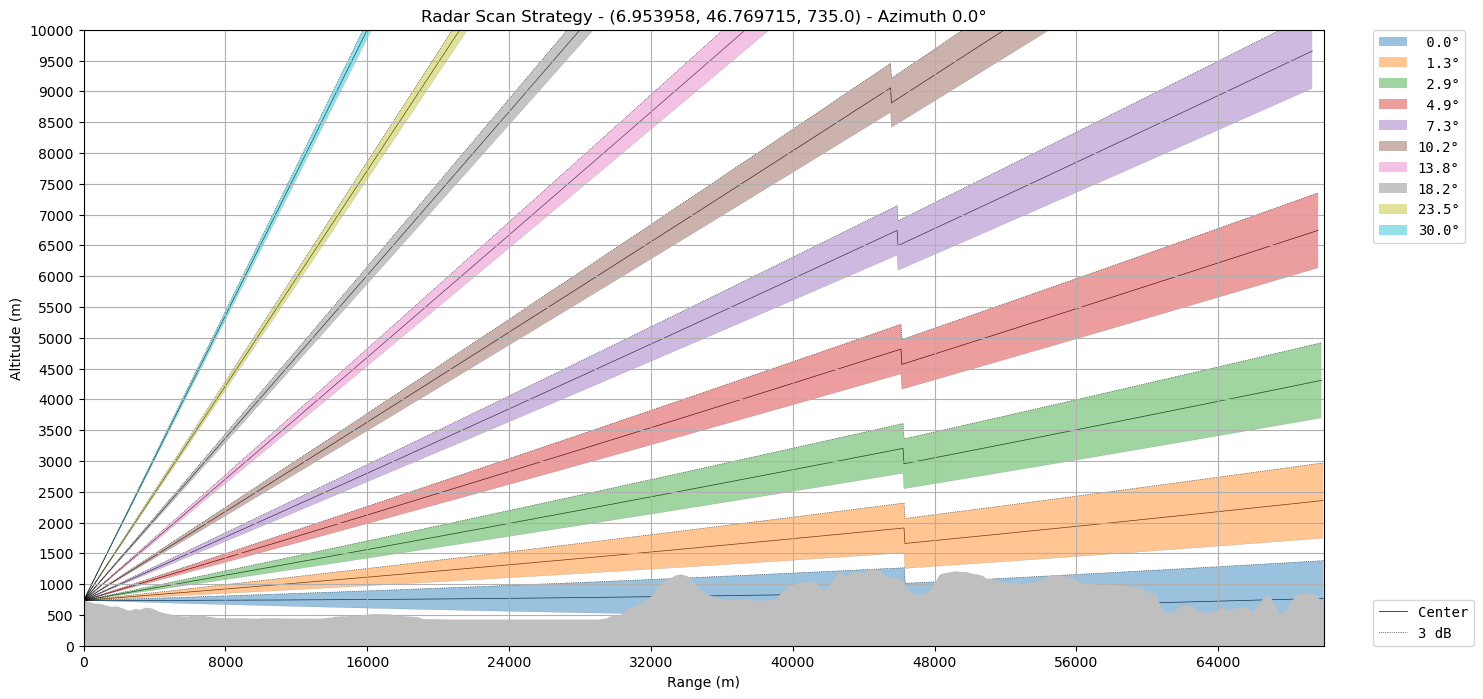

In [15]:
ax = wrl.vis.plot_scan_strategy(ranges, elevs, sitecoords, terrain=True)

Let's make the earth go round...

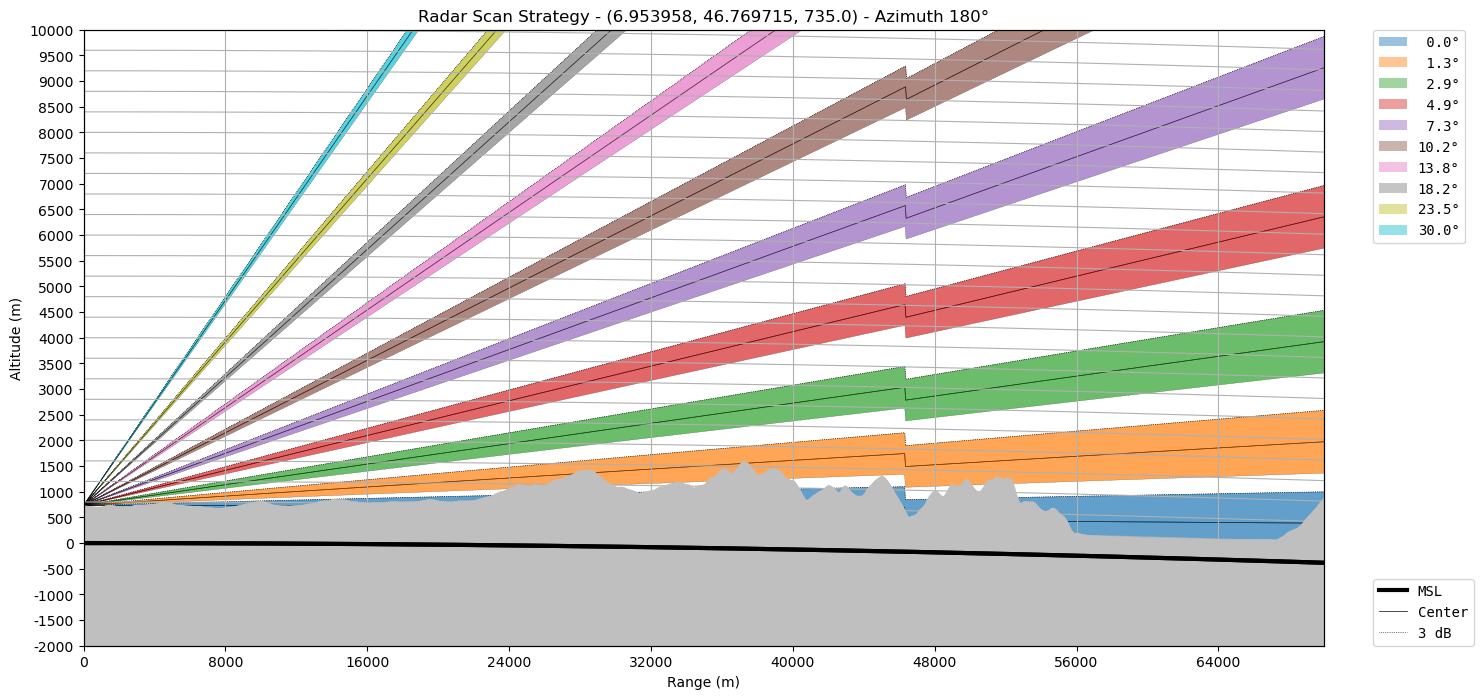

In [16]:
# "cg=True" plots in curvilinear grid and "az=180" plots the 180 degree azimuth
ax = wrl.vis.plot_scan_strategy(
    ranges, elevs, sitecoords, cg=True, terrain=True, az=180
)

## Plotting Radar Data
### Time vs. Azimuth

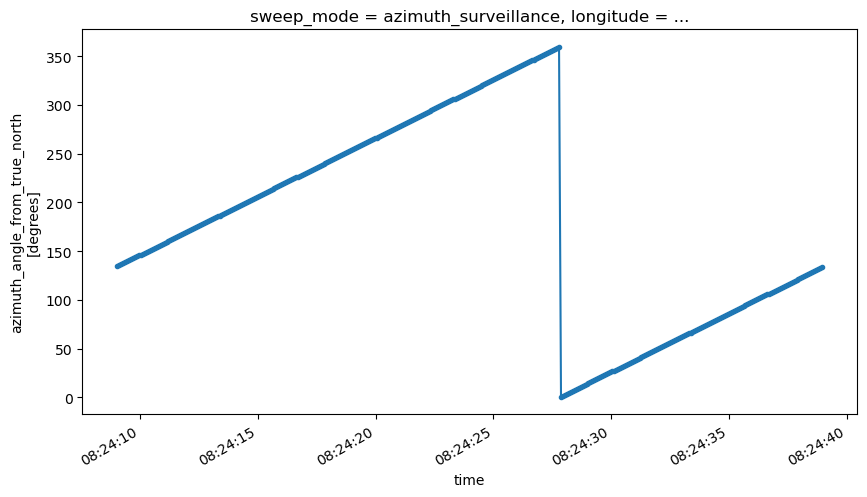

In [17]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111)
swp.azimuth.sortby("rtime").plot(x="rtime", marker=".")

### Range vs. Azimuth/Time

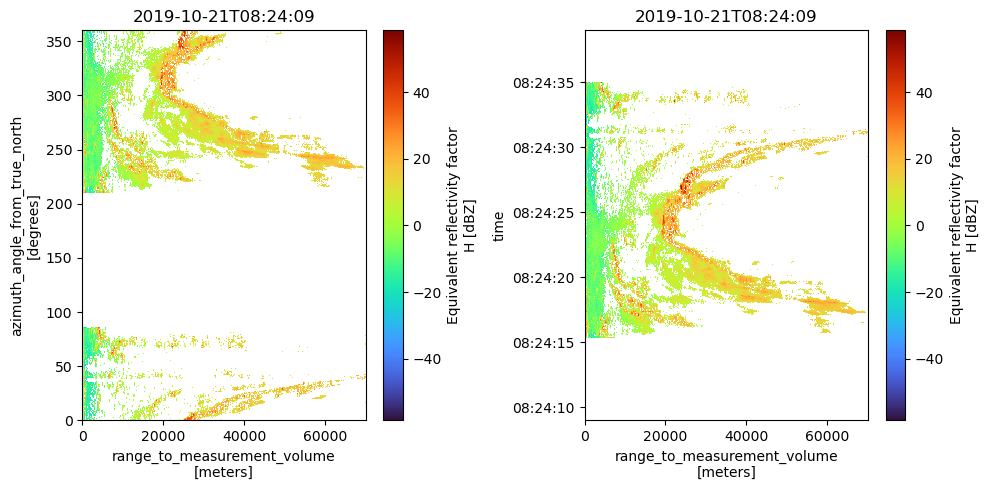

In [18]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
swp.DBZH.plot(cmap="turbo", ax=ax1)
ax1.set_title(f"{swp.time.values.astype('M8[s]')}")
ax2 = fig.add_subplot(122)
swp.DBZH.sortby("rtime").plot(y="rtime", cmap="turbo", ax=ax2)
ax2.set_title(f"{swp.time.values.astype('M8[s]')}")
plt.tight_layout()

### Georeferenced as Plan Position Indicator

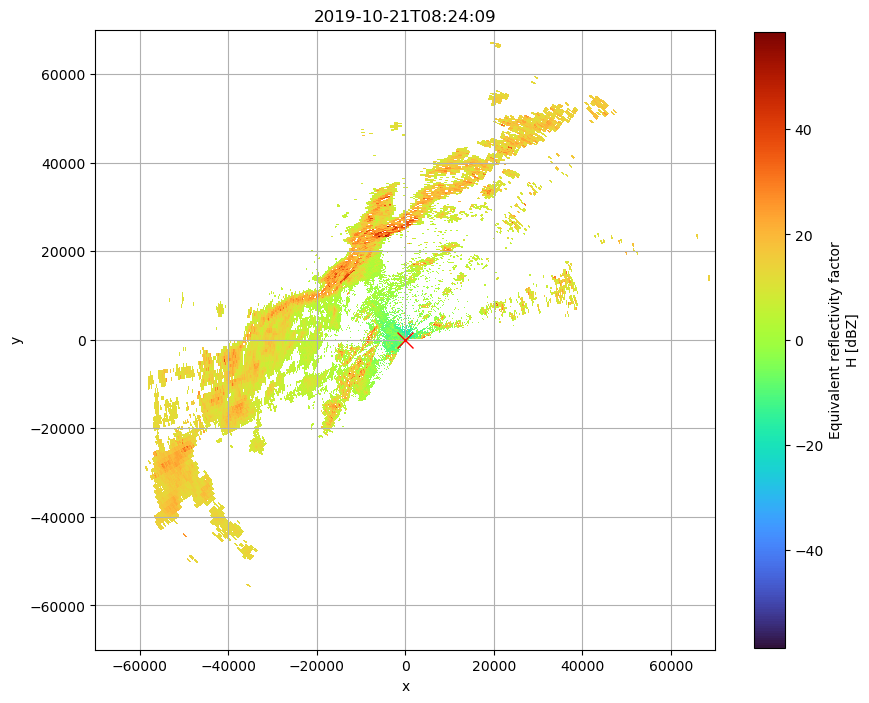

In [19]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
swp.DBZH.pipe(wrl.georef.georeference_dataset).plot(
    x="x", y="y", ax=ax1, cmap="turbo", cbar_kwargs=dict(shrink=0.8)
)
ax1.plot(0, 0, "rx", markersize=12)
ax1.set_title(f"{swp.time.values.astype('M8[s]')}")
ax1.grid()
ax1.set_aspect("equal")

### Basic MapMaking with cartopy

The data will be georeferenced as `Azimuthal Equidistant Projection` centered at the radar. For the map projection we will use `Mercator`.

In [20]:
map_trans = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values, central_longitude=swp.longitude.values
)
map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)

In [21]:
def plot_borders(ax):
    borders = cfeature.NaturalEarthFeature(
        category="cultural", name="admin_0_countries", scale="10m", facecolor="none"
    )
    ax.add_feature(borders, edgecolor="black", lw=2, zorder=4)

D:\Miniconda3\envs\wradlib\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_countries.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


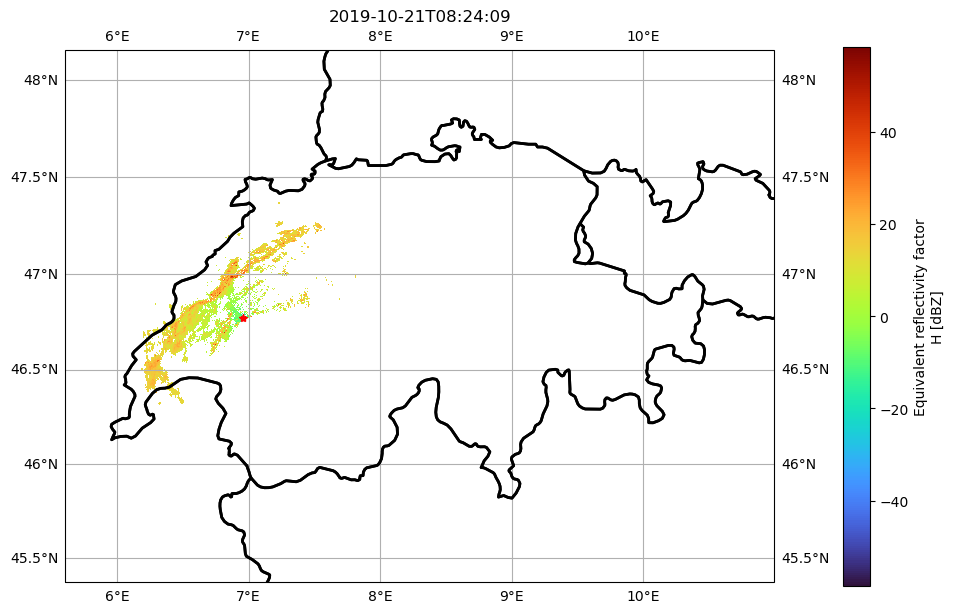

In [22]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)
cbar_kwargs = dict(shrink=0.7, pad=0.075)
pm = swp.DBZH.pipe(wrl.georef.georeference_dataset).plot(
    ax=ax, x="x", y="y", cbar_kwargs=cbar_kwargs, cmap="turbo", transform=map_trans
)
plot_borders(ax)
ax.gridlines(draw_labels=True)
ax.plot(
    swp.longitude.values, swp.latitude.values, transform=map_trans, marker="*", c="r"
)
ax.set_title(f"{swp.time.values.astype('M8[s]')}")
ax.set_xlim(-15e4, 45e4)
ax.set_ylim(565e4, 610e4)
plt.tight_layout()

### Plot on curvelinear grid

For Xarray DataArrays wradlib uses a so-called accessor (`wradlib`). To plot on curvelinear grids projection has to be set to `cg`, which uses the matplotlib AXISARTIS namespace.

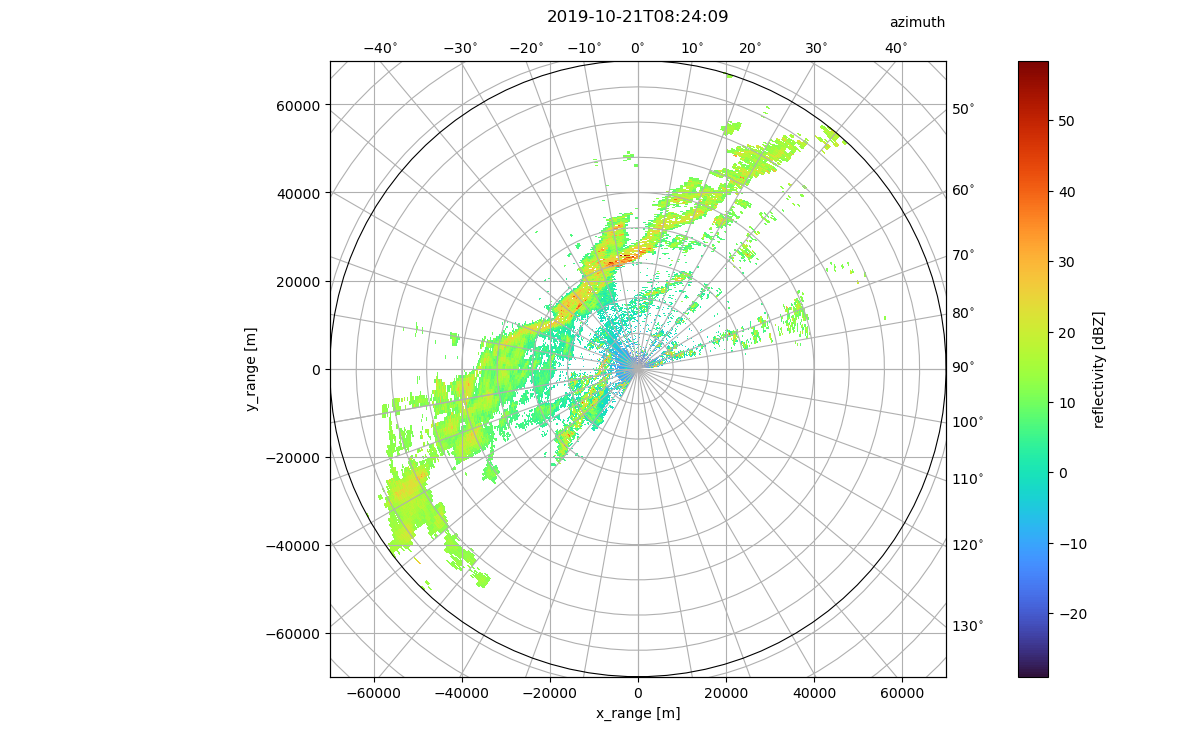

In [23]:
fig = plt.figure(figsize=(14, 8))

pm = swp.DBZH.pipe(wrl.georef.georeference_dataset).wradlib.plot(
    proj="cg", fig=fig, cmap="turbo"
)

ax = plt.gca()

# apply eye-candy
caax = ax.parasites[0]
paax = ax.parasites[1]
ax.parasites[1].set_aspect("equal")
t = plt.title(f"{vol[0].time.values.astype('M8[s]')}", y=1.05)
cbar = plt.colorbar(pm, pad=0.075, ax=paax)
caax.set_xlabel("x_range [m]")
caax.set_ylabel("y_range [m]")
plt.text(1.0, 1.05, "azimuth", transform=caax.transAxes, va="bottom", ha="right")
cbar.set_label("reflectivity [dBZ]")

## ODIM_H5 format export and import
### Export to ODIM_H5

In [24]:
vol.to_odim("test_odim_vol.h5", source="RAD")

### Import from ODIM_H5

In [26]:
vol2 = wrl.io.open_odim_dataset("test_odim_vol.h5")
display(vol2)

D:\Miniconda3\envs\wradlib\Lib\site-packages\wradlib\io\hdf.py:92: FutureWarning: `open_odim_dataset` functionality has been moved to `xradar`-package and will be removed in 2.0. Use `open_odim_datatree` from `xradar`-package.
  return open_radar_dataset(filename_or_obj, engine=OdimBackendEntrypoint, **kwargs)


<wradlib.RadarVolume>
Dimension(s): (sweep: 10)
Elevation(s): (0.0, 1.3, 2.9, 4.9, 7.3, 10.2, 13.8, 18.2, 23.5, 30.0)

In [27]:
display(vol2[0])

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 1400)
Coordinates:
  * azimuth            (azimuth) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation          (azimuth) float32 ...
    rtime              (azimuth) datetime64[ns] ...
  * range              (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
    sweep_mode         <U20 ...
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
    time               datetime64[ns] 2019-10-21T08:24:09.041666816
Data variables:
    DBZH               (azimuth, range) float32 ...
    KDP                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    RHOHV              (azimuth, range) float32 ...
    VRADH              (azimuth, range) float32 ...
    WRADH              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    sweep_number       int32 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 0.0
Attributes:
    fixed_angle:  0.0

## Import with xarray backends

We can facilitate the xarray backend's which wradlib provides for the different readers. The xarray backends are capable of loading data into a single Dataset for now. So we need to give some information here too.

### Open single files

The simplest case can only open one file and one group a time!

In [28]:
ds = xr.open_dataset("test_odim_vol.h5", engine="odim", group="dataset1")
display(ds)

ValueError: invalid literal for int() with base 10: 't1'

### Open multiple files

Here we just specify the group, which in case of rainbow files is given by the group number.

In [ ]:
ds = xr.open_mfdataset(fglob, engine="rainbow", group=0, combine="by_coords")
display(ds)

## Gridding and Export to GIS formats

- get coordinates from source Dataset with given projection
- calculate target coordinates
- grid using wradlib interpolator
- export to single band geotiff
- use GDAL CLI tools to convert to grayscaled/paletted PNG

In [ ]:
def get_target_grid(ds, nb_pixels):
    xgrid = np.linspace(ds.x.min(), ds.x.max(), nb_pixels, dtype=np.float32)
    ygrid = np.linspace(ds.y.min(), ds.y.max(), nb_pixels, dtype=np.float32)
    grid_xy_raw = np.meshgrid(xgrid, ygrid)
    grid_xy_grid = np.dstack((grid_xy_raw[0], grid_xy_raw[1]))
    return xgrid, ygrid, grid_xy_grid


def get_target_coordinates(grid):
    grid_xy = np.stack((grid[..., 0].ravel(), grid[..., 1].ravel()), axis=-1)
    return grid_xy


def get_source_coordinates(ds):
    xy = np.stack((ds.x.values.ravel(), ds.y.values.ravel()), axis=-1)
    return xy


def coordinates(da, proj, res=100):
    # georeference single sweep
    da = da.pipe(wrl.georef.georeference_dataset, proj=proj)
    # get source coordinates
    src = get_source_coordinates(da)
    # create target grid
    xgrid, ygrid, trg = get_target_grid(da, res)
    return src, trg


def moment_to_gdal(da, trg_grid, driver, ext, path="", proj=None):
    # use wgs84 pseudo mercator if no projection is given
    if proj is None:
        proj = wrl.georef.epsg_to_osr(3857)
    t = da.time.values.astype("M8[s]").astype("O")
    outfilename = f"gridded_{da.name}_{t:%Y%m%d}_{t:%H%M%S}"
    outfilename = os.path.join(path, outfilename)
    f = pathlib.Path(outfilename)
    f.unlink(missing_ok=True)
    res = ip_near(da.values.ravel(), maxdist=1000).reshape(
        (len(trg_grid[0]), len(trg_grid[1]))
    )
    data, xy = wrl.georef.set_raster_origin(res, trg_grid, "upper")
    ds = wrl.georef.create_raster_dataset(data, xy, projection=proj)
    wrl.io.write_raster_dataset(outfilename + ext, ds, driver)

### Coordinates

In [ ]:
%%time
epsg_code = 2056
proj = wrl.georef.epsg_to_osr(epsg_code)
src, trg = coordinates(ds, proj, res=1400)

### Interpolator

In [ ]:
%%time
ip_near = wrl.ipol.Nearest(src, trg.reshape(-1, trg.shape[-1]), remove_missing=7)

### Gridding and Export

In [ ]:
%%time
moment_to_gdal(ds.DBZH, trg, "GTiff", ".tif", proj=proj)

### GDAL info on created GeoTiff

In [ ]:
!gdalinfo gridded_DBZH_20191021_082409.tif

### Translate exported GeoTiff to grayscale PNG

In [ ]:
!gdal_translate -of PNG -ot Byte -scale -30. 60. 0 255 gridded_DBZH_20191021_082409.tif grayscale.png

### Apply colortable to PNG

In [ ]:
with open("colors.txt", "w") as f:
    f.write("0 blue\n")
    f.write("50 yellow\n")
    f.write("100 yellow\n")
    f.write("150 orange\n")
    f.write("200 red\n")
    f.write("250 white\n")

### Display exported PNG's

In [ ]:
!gdaldem color-relief grayscale.png colors.txt paletted.png

<img src="grayscale.png" width=400 alt="grayscale png" align="left"></img>
<img src="paletted.png" width=400 alt="paletted png" align="left"></img>

### Import with Xarray, rasterio backend

In [ ]:
with xr.open_dataset("gridded_DBZH_20191021_082409.tif", engine="rasterio") as ds_grd:
    display(ds_grd)
    ds_grd.band_data.plot(cmap="turbo")

### Import with xradar

We can use xradar to open the rainbow files, but only one at the time

In [34]:
files = glob.glob(fglob)
vol_xd = xd.io.open_rainbow_datatree(files[0])

In [41]:
vol_xd

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int32 0
│       platform_type        <U5 'fixed'
│       instrument_type      <U5 'radar'
│       time_coverage_start  <U20 '2019-10-21T08:24:09Z'
│       time_coverage_end    <U20 '2019-10-21T08:29:33Z'
│       longitude            float64 6.954
│       altitude             float64 735.0
│       latitude             float64 46.77
│   Attributes:
│       Conventions:      None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
│       instrument_name:  None
├── DataTree('sweep_0')
│       Dimensions:            (azimuth: 360, range: 1400)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.4999 1.505 2.505 ... 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
│           time               (azimuth) datetime64[ns] 2019-10-21T08:24:27.875000 .....
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int32 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_1')
│       Dimensions:            (azimuth: 360, range: 1400)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.4999 1.5 2.499 ... 357.5 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
│           time               (azimuth) datetime64[ns] 2019-10-21T08:24:57.208333500...
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int32 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_2')
│       Dimensions:            (azimuth: 360, range: 1400)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.4999 1.502 2.499 ... 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
│           time               (azimuth) datetime64[ns] 2019-10-21T08:25:27.291666500...
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int32 ...
│           prt_mode           <U7 ...
│           follow_mode        <U7 ...
│           sweep_fixed_angle  float64 ...
├── DataTree('sweep_3')
│       Dimensions:            (azimuth: 360, range: 1400)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.4999 1.502 2.499 ... 358.5 359.5
│           elevation          (azimuth) float64 ...
│         * range              (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
│           time               (azimuth) datetime64[ns] 2019-10-21T08:25:57.541666500...
│           longitude          float64 ...
│           latitude           float64 ...
│           altitude           float64 ...
│       Data variables:
│           DBZH               (azimuth, range) float32 ...
│           sweep_mode         <U20 ...
│           sweep_number       int32 ...
│           prt_mode          

In [45]:
vol_xd["sweep_9"]

DataTree('sweep_9', parent="root")
    Dimensions:            (azimuth: 360, range: 1400)
    Coordinates:
      * azimuth            (azimuth) float64 0.4999 1.502 2.497 ... 358.5 359.5
        elevation          (azimuth) float64 ...
      * range              (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
        time               (azimuth) datetime64[ns] 2019-10-21T08:29:27.541666499...
        longitude          float64 ...
        latitude           float64 ...
        altitude           float64 ...
    Data variables:
        DBZH               (azimuth, range) float32 ...
        sweep_mode         <U20 ...
        sweep_number       int32 ...
        prt_mode           <U7 ...
        follow_mode        <U7 ...
        sweep_fixed_angle  float64 ...

### Export to ODIM with xradar

In [ ]:
xd.io.to_odim(vol, "test_odim_vol.h5")

---

## Summary
We've just learned how to use $\omega radlib$'s xarray backends to make radar volume data available as xarray Datasets and DataArrays. Accessing, plotting and exporting data has been shown.

### What's next?
In the next notebook we dive into data quality processing.

## Resources and references

- [xarray](https://docs.xarray.dev)
- [dask](https://docs.dask.org)
- [matplotlib](https://matplotlib.org/stable/index.html)
- [matplotlib axisartist](https://matplotlib.org/stable/tutorials/toolkits/axisartist.html)
- [cartopy](https://scitools.org.uk/cartopy/docs/latest)
- [gdal](https://gdal.org/index.html)
- [wradlib xarray backends](https://docs.wradlib.org/en/stable/notebooks/fileio/wradlib_xarray_backends.html)
- [rioxarray](https://corteva.github.io/rioxarray/stable/)
- [wradlib scan strategy](https://docs.wradlib.org/en/stable/notebooks/visualisation/wradlib_plot_scan_strategy.html)
- [Leonardo - Rainbow5](https://electronics.leonardo.com/en/products/rainbow-5-application-software)
- [OPERA ODIM_H5](https://www.eumetnet.eu/activities/observations-programme/current-activities/opera/)
- [WMO JET-OWR](https://community.wmo.int/governance/commission-membership/commission-observation-infrastructure-and-information-systems-infcom/commission-infrastructure-officers/infcom-management-group/standing-committee-measurements-instrumentation-and-traceability-sc-mint/joint-expert-team)